In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [2]:
cotar_samples = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv", index_col=0)

In [3]:
cotar_samples.head()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,label,star_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,ra,dec
0,131116000501262,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,...,1,03303061-6824089,5848.8174,109.977853,4.243084,0.184408,-0.338275,0.134476,52.627905,-68.402358
1,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,2,04315418-5613335,4328.7964,118.017575,3.327391,0.198075,0.169383,0.128575,67.975753,-56.225897
2,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,4,04303269-5730244,3136.7622,NaN,4.396316,NaN,NaN,NaN,67.635947,-57.506949
3,131118002401396,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,...,2,04354318-5738560,4815.8853,140.982633,3.473381,0.215505,-0.916787,0.134253,68.930000,-57.648952
4,131118002901052,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,...,2,05292291-5823105,5056.8890,84.699254,3.586107,0.183447,-0.459082,0.065107,82.345409,-58.386368


In [4]:
from astropy.table import Table 

In [5]:
data = Table.read('/home/pravn/Dropbox/Masters/mnras-cotar-data/data.fits', format='fits')

In [7]:
cotar_original = data.to_pandas()

In [8]:
cotar_original.head()

,source_id,sobject_id,ra,dec,Ha_EW,Hb_EW,Ha_EW_abs,Hb_EW_abs,Ha_W10,Ha_EW_asym,...,SB2_c1,NII,SII,NII_EW,SII_EW,rv_NII,rv_SII,nebular,emiss,flag
0,4667368899326729856,131116000501002,53.219667,-68.675139,-0.041336,-0.128504,0.110269,0.346573,21.851629,0.018468,...,False,0,0,0.000000,0.007487,-42.985878,-52.369164,False,False,0
1,4667362989451832448,131116000501003,53.724417,-68.610056,-0.093059,-0.032066,0.136851,0.350298,12.018717,0.146598,...,False,0,0,-0.010351,0.000000,-69.839996,-75.075890,False,False,0
2,4667324643983679744,131116000501004,55.594000,-68.697833,-0.004435,0.244539,0.124381,0.360633,42.366215,-0.171434,...,False,0,0,0.013567,0.000000,-95.912048,-100.068390,False,False,0
3,4667335913977929728,131116000501005,54.392042,-68.685056,-0.063868,-0.121597,0.086837,0.173505,32.563042,0.277683,...,False,0,0,0.000000,-0.000524,38.587879,53.383396,False,False,0
4,4667323681911007232,131116000501006,55.770375,-68.722472,0.045687,-0.133048,0.112489,0.197745,16.599590,-0.051486,...,False,0,0,0.000000,0.012277,-10.203407,-128.818909,False,False,0


In [10]:
cotar_original_sobjects_ew = cotar_original[["sobject_id", "Ha_EW"]].copy()

In [11]:
cotar_original_sobjects_ew.head()

,sobject_id,Ha_EW
0,131116000501002,-0.041336
1,131116000501003,-0.093059
2,131116000501004,-0.004435
3,131116000501005,-0.063868
4,131116000501006,0.045687


In [12]:
cotar_samples_sobjects = cotar_samples[["sobject_id"]].copy()

In [13]:
cotar_samples_sobjects.head()

,sobject_id
0,131116000501262
1,131116001001379
2,131118002401234
3,131118002401396
4,131118002901052


In [14]:
df_temp = pd.merge(cotar_original_sobjects_ew,cotar_samples_sobjects, how='outer', indicator=True)

In [15]:
df_temp.head()

,sobject_id,Ha_EW,_merge
0,131116000501002,-0.041336,left_only
1,131116000501003,-0.093059,left_only
2,131116000501004,-0.004435,left_only
3,131116000501005,-0.063868,left_only
4,131116000501006,0.045687,left_only


In [16]:
df_temp["_merge"].value_counts()

left_only     651942
both            6977
right_only         0
Name: _merge, dtype: int64

In [17]:
df_final_cands = df_temp.loc[df_temp["_merge"]=="both"]

In [18]:
df_final_cands.head()

,sobject_id,Ha_EW,_merge
231,131116000501262,0.295603,both
503,131116001001379,1.089601,both
672,131118002401234,1.140538,both
747,131118002401396,0.332889,both
780,131118002901052,0.671526,both


In [19]:
df_final_cands = df_final_cands.drop(columns=["_merge"])

In [20]:
cotar_samples_ew = df_final_cands

In [21]:
cotar_samples_ew

,sobject_id,Ha_EW
231,131116000501262,0.295603
503,131116001001379,1.089601
672,131118002401234,1.140538
747,131118002401396,0.332889
780,131118002901052,0.671526
...,...,...
658571,190225004801232,0.350897
658718,190225005301010,0.376991
658792,190225005301142,0.406013
658843,190225005301225,0.681442


In [60]:
original_masked = pd.read_csv("/home/pravn/Documents/original_masked_ew_sobject_id.csv")
original_masked_halpa = original_masked[original_masked["EW"]>0.25]
df_new_emiss_25 = original_masked_halpa[original_masked_halpa["EW"]<5.5]

In [61]:
autoencoder_run = df_new_emiss_25[["sobject_id", "EW"]].copy()

In [62]:
autoencoder_run.head()

,sobject_id,EW
184,131116000501238,0.354939
344,131116001001352,2.129203
354,131116001001379,1.298985
415,131118002401234,1.134192
463,131118002901020,0.515890


In [63]:
cotar_samples_ew["Ha_EW"].describe()

count    6977.000000
mean        0.541501
std         0.436802
min         0.250070
25%         0.296211
50%         0.387524
75%         0.585730
max         5.369496
Name: Ha_EW, dtype: float64

In [64]:
autoencoder_run["EW"].describe()

count    10625.000000
mean         0.548869
std          0.456927
min          0.250038
25%          0.298722
50%          0.382098
75%          0.586963
max          4.866757
Name: EW, dtype: float64

Cotar EW Distribution

<AxesSubplot:>

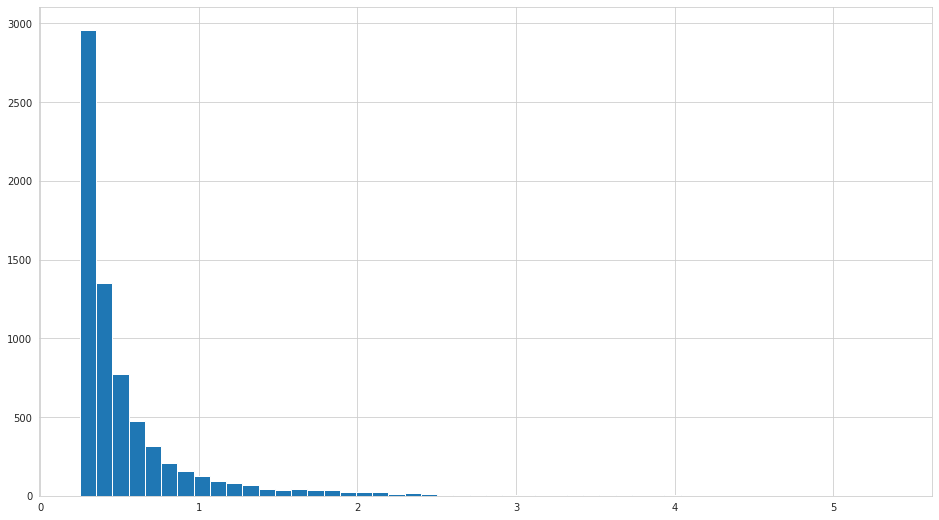

In [65]:
cotar_samples_ew["Ha_EW"].hist(bins=50)

Autoencoder EW Distribution

<AxesSubplot:>

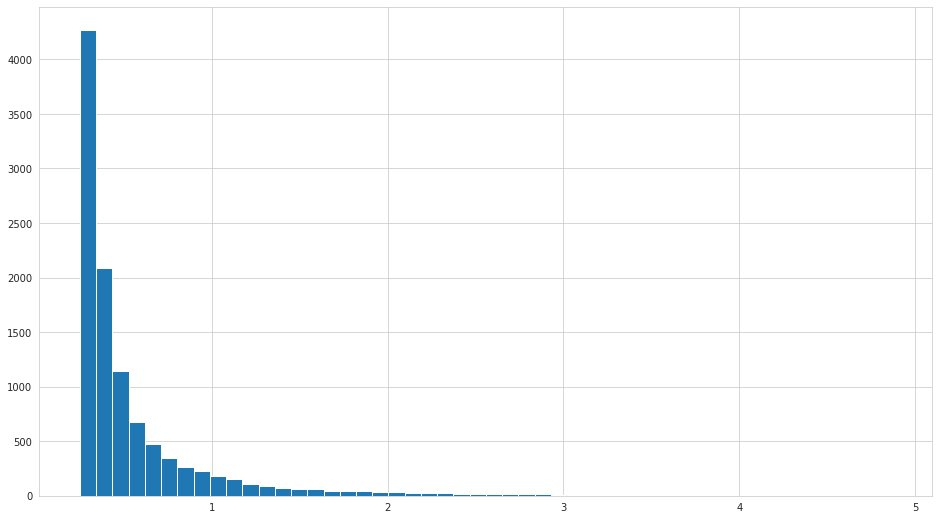

In [66]:
autoencoder_run["EW"].hist(bins=50)

In [67]:
df_temp_2 = pd.merge(autoencoder_run,cotar_samples_ew, how='outer', indicator=True, on="sobject_id")

In [68]:
df_temp_2["_merge"].value_counts()

left_only     6513
both          4112
right_only    2865
Name: _merge, dtype: int64

In [69]:
df_temp_2

,sobject_id,EW,Ha_EW,_merge
0,131116000501238,0.354939,NaN,left_only
1,131116001001352,2.129203,NaN,left_only
2,131116001001379,1.298985,1.089601,both
3,131118002401234,1.134192,1.140538,both
4,131118002901020,0.515890,NaN,left_only
...,...,...,...,...
13485,190225002101279,NaN,0.364038,right_only
13486,190225002701366,NaN,0.288659,right_only
13487,190225003201057,NaN,0.573976,right_only
13488,190225003701354,NaN,0.452212,right_only


In [38]:
df_both = df_temp_2.loc[df_temp_2["_merge"]=="both"]

<AxesSubplot:>

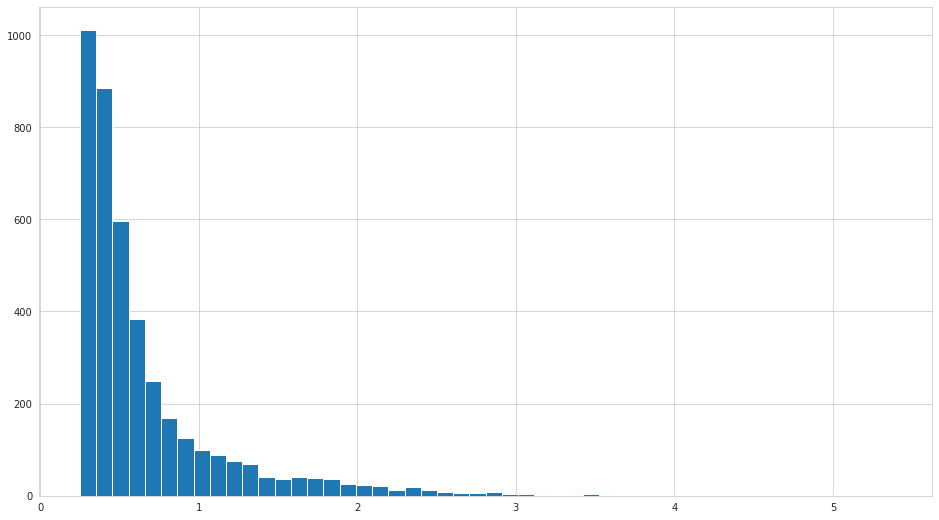

In [39]:
df_both["Ha_EW"].hist(bins=50)

<AxesSubplot:>

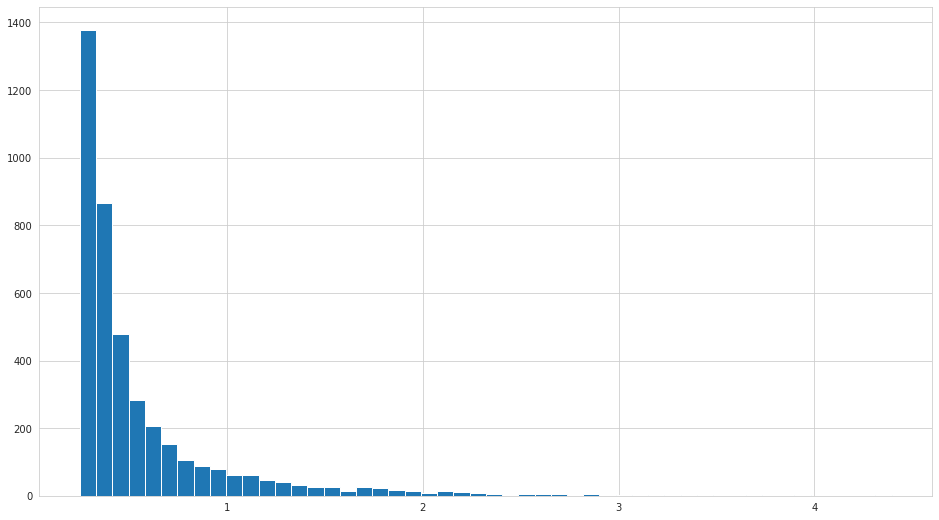

In [40]:
df_both["EW"].hist(bins=50)